#### Лаба 3

#### задачи траекторного управления

### Given

In [3]:
import sympy as sm
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from IPython.display import display, Math
import inspect
import bisect

In [4]:
# robot model parameters
m = 2.8 # in kg
J = 3 # in kg*m

In [5]:
x, y, omega, alpha, alpha_asterisk, vx, vy, Fx, Fy, M  = sm.symbols("x y omega alpha alpha_asterisk vx vy Fx Fy M")
A = sm.Matrix( [[1/m,0,0],[0,1/m,0],[0,0,1/J]] )
z = sm.Matrix( [[vx],[vy],[omega]] ) # in m frame
u = sm.Matrix( [[Fx],[Fy],[M]] )
R = sm.Matrix( [[sm.cos(alpha),sm.sin(alpha)],[-sm.sin(alpha),sm.cos(alpha)]] ) # from mobile to base

In [45]:
def display_expr(expr):
    frame = inspect.currentframe()
    frame = inspect.getouterframes(frame)[1]
    string = inspect.getframeinfo(frame[0]).code_context[0].strip()
    args = string[string.find('(') + 1:-1].split(',')
    
    names = []
    for i in args:
        if i.find('=') != -1:
            names.append(i.split('=')[1].strip())
        else:
            names.append(i)
    if names[0]=='phi_1':
        names[0] = '\\varphi_1'
    if names[0]=='phi_2':
        names[0] = '\\varphi_2'
    if names[0]=='phi_3':
        names[0] = '\\varphi_3'
    if names[0]=='vm':
        names[0] = 'v_m'
    if names[0]=='vb':
        names[0] = 'v_b'
    if names[0]=='dots':
        names[0] = '\\dot s'
    if names[0]=='dote':
        names[0] = '\\dot e'
    if names[0]=='xi':
        names[0] = '\\xi'

    expr = expr.xreplace({n : round(n, 3) for n in expr.atoms(sm.Number)})
    str = sm.latex(expr)
    # str = str.replace('\\theta','\\vartheta')
    str = str.replace('vx','v_x')
    str = str.replace('vy','v_y')
    str = str.replace('Fx','F_x')
    str = str.replace('Fy','F_y') 
    str = str.replace('\\alpha_{asterisk}','\\alpha^{*}') 
    str = str.replace('dotxi','\\dot \\xi')
    str = str.replace('\\xi_{dxds}','\\frac{\partial x_{\\xi}(s)}{\partial s}') 

    display(Math(names[0] + '=' + str))    

In [7]:
Au = A*u
display_expr(Au)

<IPython.core.display.Math object>

In [8]:
vm = sm.Matrix([[vx],[vy]])
display_expr(vm)
vb = R*vm
display_expr(vb)
dots = (sm.transpose(R.subs(alpha,alpha_asterisk))*vb)[0]
display_expr(dots)
dote = (sm.transpose(R.subs(alpha,alpha_asterisk))*vb)[1]
display_expr(dote)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [9]:
a = (1/m)*sm.transpose(R)*sm.Matrix([[Fx],[Fy]])
display_expr(a)

<IPython.core.display.Math object>

### Traj phi

In [10]:
#trajectory
x0 = -7
y0 = 4
alpha0 = 3*np.pi/4
vs_des1 = 1 
vs_des2 = 3
vs_des3 = 5

R1 = 3
xc1 = -3
yc1 = 2
R3 = 5
xc3 = 12
yc3 = 2
phi_1 = (x-xc1)**2+(y-yc1)**2-R1**2
phi_2 = -2*sm.cos(0.5*x+0.3)+y-2
phi_3 = (x-xc3)**2 + (y-yc3)**2 - R3**2
display_expr(phi_1)
display_expr(phi_2)
display_expr(phi_3)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [11]:
calc_phi_1_y = sm.solve(phi_1, y)
display(Math(sm.latex(calc_phi_1_y)))

<IPython.core.display.Math object>

In [12]:
calc_phi_2_y = sm.solve(phi_2, y)
display(Math(sm.latex(calc_phi_2_y)))

<IPython.core.display.Math object>

In [13]:
calc_phi_3_y = sm.solve(phi_3, y)
display(Math(sm.latex(calc_phi_3_y)))

<IPython.core.display.Math object>

### Traj calc

In [14]:
params = tuple(calc_phi_1_y[0].free_symbols)
print(params)
fun_calc_phi_11_y = sm.lambdify(params, calc_phi_1_y[0], modules='numpy')
params = tuple(calc_phi_1_y[1].free_symbols)
print(params)
fun_calc_phi_12_y = sm.lambdify(params, calc_phi_1_y[1], modules='numpy')

params = tuple(calc_phi_2_y[0].free_symbols)
print(params)
fun_calc_phi_2_y = sm.lambdify(params, calc_phi_2_y[0], modules='numpy')

params = tuple(calc_phi_3_y[0].free_symbols)
print(params)
fun_calc_phi_31_y = sm.lambdify(params, calc_phi_3_y[0], modules='numpy')
params = tuple(calc_phi_3_y[1].free_symbols)
print(params)
fun_calc_phi_32_y = sm.lambdify(params, calc_phi_3_y[1], modules='numpy')

(x,)
(x,)
(x,)
(x,)
(x,)


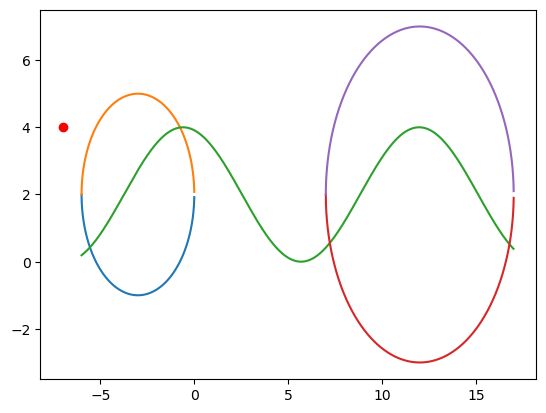

In [15]:
x1 = np.arange(xc1-R1,xc1+R1,1e-3)
x2 = np.arange(-6,17,1e-2)
x3 = np.arange(xc3-R3,xc3+R3,1e-3)
plt.plot(x1,fun_calc_phi_11_y(x1))
plt.plot(x1,fun_calc_phi_12_y(x1))
plt.plot(x2,fun_calc_phi_2_y(x2))
plt.plot(x3,fun_calc_phi_31_y(x3))
plt.plot(x3,fun_calc_phi_32_y(x3))
plt.plot(x0,y0,"or")

In [16]:
#поиск точек переключений
def calc_fun_optim_finding_x(x):
    return (fun_calc_phi_12_y(x)-fun_calc_phi_2_y(x))**2
xsw1 = sp.optimize.minimize_scalar(calc_fun_optim_finding_x,bounds=(xc1-R1,xc1+R1),method='bounded').x
print(xsw1)

-0.7583442022818133


In [17]:
def calc_fun_optim_finding_x(x):
    return (fun_calc_phi_2_y(x)-fun_calc_phi_31_y(x))**2
xsw2 = sp.optimize.minimize_scalar(calc_fun_optim_finding_x,bounds=(xc3,xc3+R3),method='bounded').x
print(xsw2)
xsw3 = xc3-R3

16.775623130982034


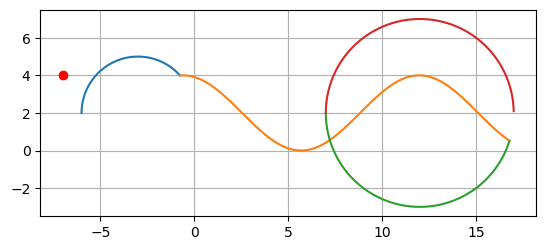

In [18]:
# desired traj
x1 = np.arange(xc1-R1,xsw1,1e-3)
x2 = np.arange(xsw1,xsw2,1e-2)
x3 = np.arange(xsw3,xsw2,1e-3)
x4 = np.arange(xsw3,xc3+R3,1e-3)
plt.plot(x1,fun_calc_phi_12_y(x1))
plt.plot(x2,fun_calc_phi_2_y(x2))
plt.plot(x3,fun_calc_phi_31_y(x3))
plt.plot(x4,fun_calc_phi_32_y(x4))
plt.plot(x0,y0,"or")
plt.grid(True)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

### S calc

In [19]:
def s_1(x):
    return (np.pi - np.arccos((x-xc1)/R1) )*R1

In [20]:
# compute s paths
L_2 = sm.sqrt( 1 + ( sm.diff(calc_phi_2_y[0],x) )**2 )
display_expr(L_2)

params = tuple(L_2.free_symbols)
calc_s_2_int = sm.lambdify(params, L_2, modules='numpy')

def s_2(x):
    return sp.integrate.quad(calc_s_2_int,xsw1,x)[0]

<IPython.core.display.Math object>

In [21]:
def s_3(x):
    return np.arccos((x-xc3)/R3)*R3 - np.arccos((xsw2-xc3)/R3)*R3
def s_4(x):
    return (np.pi - np.arccos((x-xc3)/R3) )*R3

### finding $s_0$

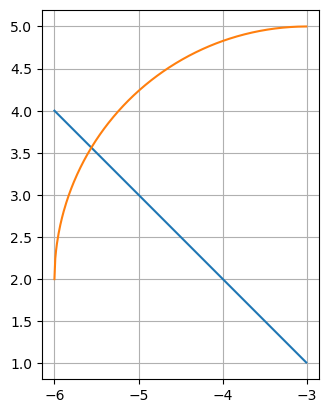

In [22]:
t_data = np.arange(xc1-R1,xc1,1e-2)
plt.plot(t_data,(t_data-(xc1-R1))*np.tan(alpha0 - np.pi) + y0)
plt.plot(t_data,fun_calc_phi_12_y(t_data))
plt.grid(True)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

In [23]:
# finding s0
def fun_optim_s0(x):
    return ( (x-(xc1-R1))*np.tan(alpha0 - np.pi) + y0 - fun_calc_phi_12_y(x) )**2

x0_4s0 = sp.optimize.minimize_scalar(fun_optim_s0,bounds=(xc1-R1,xc1),method='bounded').x
s0 = s_1(x0_4s0)
print(x0_4s0)
print(s0)

-5.561554301636298
1.6423682554168422


In [24]:
s_len = s_1(xsw1) + s_2(xsw2) + s_3(xc3-R3) + s_4(xc3+R3)
print(s_len)
s_all = [0,s_1(xsw1),s_1(xsw1) + s_2(xsw2),s_1(xsw1) + s_2(xsw2) + s_3(xc3-R3),s_1(xsw1) + s_2(xsw2) + s_3(xc3-R3) + s_4(xc3+R3)]
print(s_all)
print(s_all[2]-s_all[1])
print(s_all[3]-s_all[2])
print(s_all[4]-s_all[3])

58.64969623920736
[0, 7.243989865398947, 28.737350135440845, 42.94173297125839, 58.64969623920736]
21.493360270041897
14.204382835817544
15.70796326794897


### control preaparing

$\Upsilon(x,y)$ = $\begin{bmatrix} \frac{\partial \psi(x,y)}{\partial x} & \frac{\partial \psi(x,y)}{\partial y} \\ & \\\frac{\partial \varphi(x,y)}{\partial x} & \frac{\partial \varphi(x,y)}{\partial y} \end{bmatrix}$

In [25]:
# calc alpha_asterisk
s = sm.symbols("s")
phi_12_x = sm.solve( ( sm.pi - sm.acos((x-xc1)/R1) )*R1 - s , x)[0] 
params = tuple(phi_12_x.free_symbols)
calc_phi_1_x = sm.lambdify(params, phi_12_x, modules='numpy')

dotphi_1 = sm.diff(calc_phi_1_y[1],x)
params = tuple(dotphi_1.free_symbols)
calc_dotphi_1 = sm.lambdify(params, dotphi_1, modules='numpy')

def fun_optim_s2_x(x,s):
    return (s_2(x)-s)**2
def calc_phi_2_x(s):
    return sp.optimize.minimize(fun_optim_s2_x,(xsw1+xsw2)/2,args=s).x[0]
dotphi_2 = sm.diff(calc_phi_2_y[0],x)
params = tuple(dotphi_2.free_symbols)
calc_dotphi_2 = sm.lambdify(params, dotphi_2, modules='numpy')

phi_3_x = sm.solve( (sm.acos((x-xc3)/R3))*R3 - (sm.acos((xsw2-xc3)/R3))*R3 - s , x )[0] 
params = tuple(phi_3_x.free_symbols)
calc_phi_3_x = sm.lambdify(params, phi_3_x, modules='numpy')

dotphi_3 = sm.diff(calc_phi_3_y[0],x)
params = tuple(dotphi_3.free_symbols)
calc_dotphi_3 = sm.lambdify(params, dotphi_3, modules='numpy')

phi_4_x = sm.solve( (sm.pi - sm.acos((x-xc3)/R3) )*R3 - s , x )[0] 
params = tuple(phi_4_x.free_symbols)
calc_phi_4_x = sm.lambdify(params, phi_4_x, modules='numpy')

dotphi_4 = sm.diff(calc_phi_3_y[1],x)
params = tuple(dotphi_4.free_symbols)
calc_dotphi_4 = sm.lambdify(params, dotphi_4, modules='numpy')

def calc_alpha_asterisk(s):
    if s<=0:
        val_asterisk = 1e6
    elif s>=s_all[4]:
        val_asterisk = -1e6
    elif s==s_all[3]:
        val_asterisk = 1e6
    elif s==s_all[2]:
        val_asterisk = 1.7523330864423152
    elif s==s_all[1]: 
        val_asterisk = -0.5226298800644945
    else:
        i = search_index(s)
        if i==len(s_all)-1:
            i-=1
        if i==0:
            x = calc_phi_1_x(s)
            val_asterisk = calc_dotphi_1(x)
        elif i==1:
            x = calc_phi_2_x(s-s_all[1])
            val_asterisk = calc_dotphi_2(x)
        elif i==2:
            x = calc_phi_3_x(s-s_all[2])
            val_asterisk = calc_dotphi_3(x)
        elif i==3:
            x = calc_phi_4_x(s-s_all[3])
            val_asterisk = calc_dotphi_4(x)
        
        # print(i)
        # print(x)
    return val_asterisk

def search_index(x):
    return bisect.bisect(s_all,x) - 1

# calc_alpha_asterisk((s_all[4]-s_all[3])/2+s_all[3])
# calc_alpha_asterisk(58)
# (calc_dotphi_3(calc_phi_3_x(s_all[2])) + calc_dotphi_2(calc_phi_2_x(s_all[2]-s_all[1])) ) /2
# (calc_alpha_asterisk(s_all[1]-1e-6) + calc_alpha_asterisk(s_all[1]))/2

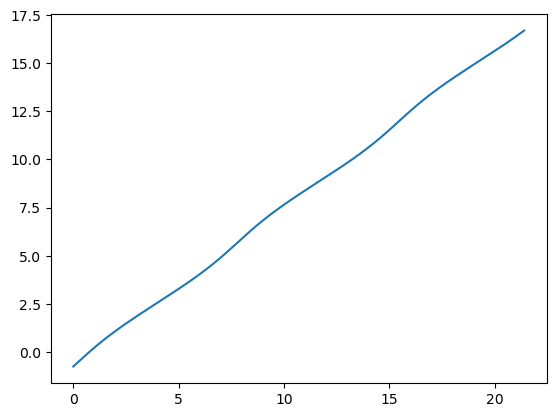

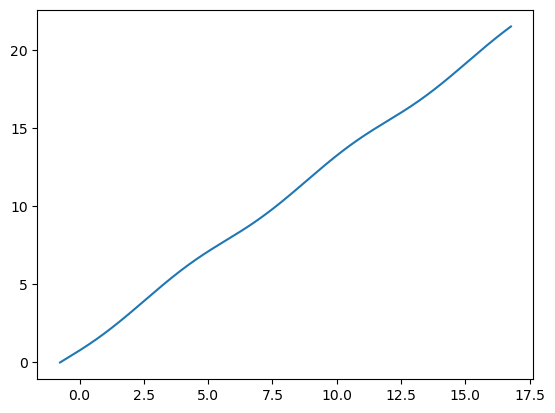

In [55]:
s_vals = np.arange(0,s_all[2]-s_all[1]-1e-3,1e-1)
x_vals = []
for i in range(len(s_vals)):
    x_vals.append(calc_phi_2_x(s_vals[i]))
plt.plot(s_vals,x_vals)
plt.show()

x_vals = np.arange(xsw1,xsw2,1e-2)
s2_vals = []
for i in range(len(x_vals)):
    s2_vals.append(s_2(x_vals[i]))
plt.plot(x_vals,s2_vals)
plt.show()

In [26]:
# calc curvature of second path
dotphi_2_y = sm.diff(phi_2,y)
ddotphi_2_yy = sm.diff(dotphi_2_y,y)
dotphi_2_x = sm.diff(phi_2,x)
ddotphi_2_xx = sm.diff(dotphi_2_x,x)
ddotphi_2_xy = sm.diff(dotphi_2_x,y)
display(Math(sm.latex(phi_2)))
display(Math(sm.latex(dotphi_2_y)))
display(Math(sm.latex(ddotphi_2_yy)))
display(Math(sm.latex(dotphi_2_x)))
display(Math(sm.latex(ddotphi_2_xx)))
display(Math(sm.latex(ddotphi_2_xy)))
xi = abs(dotphi_2_y**2*ddotphi_2_xx-2*dotphi_2_x*dotphi_2_y*ddotphi_2_xy+dotphi_2_x**2*ddotphi_2_yy)/((dotphi_2_x)**2+(dotphi_2_y)**2)**(3/2)
display_expr(xi)
params = tuple(xi.free_symbols)
calc_phi_2_xi = sm.lambdify(params, xi, modules='numpy')

dotxi = sm.diff( (dotphi_2_y**2*ddotphi_2_xx-2*dotphi_2_x*dotphi_2_y*ddotphi_2_xy+dotphi_2_x**2*ddotphi_2_yy)/((dotphi_2_x)**2+(dotphi_2_y)**2)**(3/2) ,x)
display_expr(dotxi)
calc_phi_2_dotxi = sm.lambdify(x, dotxi, modules='numpy')

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [27]:
# calc curvature
def calc_curvature(s):
    i = search_index(s)
    if i==len(s_all)-1:
        i-=1
    if i==0:
        xi=1/R1
    elif i==1:
        x = calc_phi_2_x(s-s_all[1])
        xi = calc_phi_2_xi(x)
    else:
        xi=1/R3
    return xi

def calc_dotcurvature(s):
    i = search_index(s)
    if i==len(s_all)-1:
        i-=1
    if i==0:
        xi=0
    elif i==1:
        x = calc_phi_2_x(s-s_all[1])
        xi = calc_phi_2_dotxi(x)
    else:
        xi=0
    return xi

def calc_xi_dxds(s):
    i = search_index(s)
    if i==len(s_all)-1:
        i-=1
    if i==0:
        xi_dxds=0
    elif i==1:
        s -= s_all[1]
        s_prev -= s_all[1]    
        xi_dxds = (calc_phi_2_x(s)-calc_phi_2_x(s_prev))/(s-s_prev)
    else:
        xi_dxds=0
    return xi_dxds

In [28]:
# calc e
calc_phi_1 = sm.lambdify((x,y), phi_1, modules='numpy')
calc_phi_2 = sm.lambdify((x,y), phi_2, modules='numpy')
calc_phi_3 = sm.lambdify((x,y), phi_3, modules='numpy')

def calc_e(x,y,s):
    i = search_index(s)
    if i==len(s_all)-1:
        i-=1
    if i==0:
        e = calc_phi_1(x,y)
    elif i==1:
        e = calc_phi_2(x,y)
    else:
        e = calc_phi_3(x,y)
    # print(i)
    return e

### Control

In [29]:
Vs = 5
T = s_all[-1]/Vs
print(T) # simulation time

11.729939247841472


In [30]:
z = sm.Matrix([[vx],[vy],[omega],[x],[y],[alpha],[s]])
display_expr(z)

<IPython.core.display.Math object>

In [84]:
rhs = sm.Matrix([Au,vb[0],vb[1],omega,dots])
display_expr(rhs)

params = tuple(dots.free_symbols)
print(params)
calc_dots = sm.lambdify(params, dots, modules='numpy')

<IPython.core.display.Math object>

(alpha_asterisk, vx, vy, alpha)


In [80]:
# control sugnals formulation
xi = sm.symbols("xi")
dotxi = sm.symbols("dotxi")
e = sm.symbols("e")
xi_dxds = sm.symbols("xi_dxds")
ks = 5
ke1 = 5
ke2 = 20
kdelta2 = 20
us = -xi*dots*dote+ks*(Vs-dots)
rhs = rhs.subs(Fx,m*(us))
rhs = rhs.subs(Fy,m*(xi*dots**2-ke1*dote-ke2*e))
rhs = rhs.subs(M,J*(xi*us+dotxi*xi_dxds*dots**2+xi**2*dots*dote - kdelta2*(alpha-alpha_asterisk)))
display_expr(rhs)

params = tuple(rhs.free_symbols)
print(params)
calc_rhs = sm.lambdify(params, rhs, modules='numpy')

<IPython.core.display.Math object>

(e, dotxi, xi_dxds, alpha_asterisk, vx, vy, omega, xi, alpha)


In [33]:
# calc_rhs(xi, alpha, e, alpha_asterisk, vy, dotxi, vx, omega)

In [170]:
def rhs(t, z):
    vx,vy,omega,x,y,alpha,s = z
    
    e = calc_e(x,y,s)
    xi = calc_curvature(s)
    dotxi = calc_dotcurvature(s)
    alpha_asterisk = calc_alpha_asterisk(s)
    dots = calc_dots(alpha_asterisk, vx, vy, alpha)
    if(sol.step_size):
        xi_dxds = calc_xi_dxds(s,s-dots*sol.step_size)
    xi_dxds = 0

    return calc_rhs(e, dotxi, xi_dxds, alpha_asterisk, vx, vy, omega, xi, alpha).reshape(1,7)[0]

In [177]:
T = 0.1
z0 = [0,0,0,x0,y0,alpha0,s0] # [vx],[vy],[omega],[x],[y],[alpha],[s]
sol = sp.integrate.RK45(rhs, 0, z0, T+3, rtol=1e-2, atol=1e-4)

In [178]:
y = np.array([]).reshape(7,0)
t = np.array([0])
while sol.t <= T:
    sol.step()
    y = np.hstack((y, np.array(sol.y).reshape(7,1)) )
    t = np.append(t,t[-1] + sol.step_size)

In [ ]:
# z0 = [0,0,0,x0,y0,alpha0,s0] # [vx],[vy],[omega],[x],[y],[alpha],[s]
# sol = sp.integrate.solve_ivp(rhs, [0, 0.3], z0,method='RK45', dense_output=False,rtol=1e-2, atol=1e-4)

In [179]:
len(t)

6

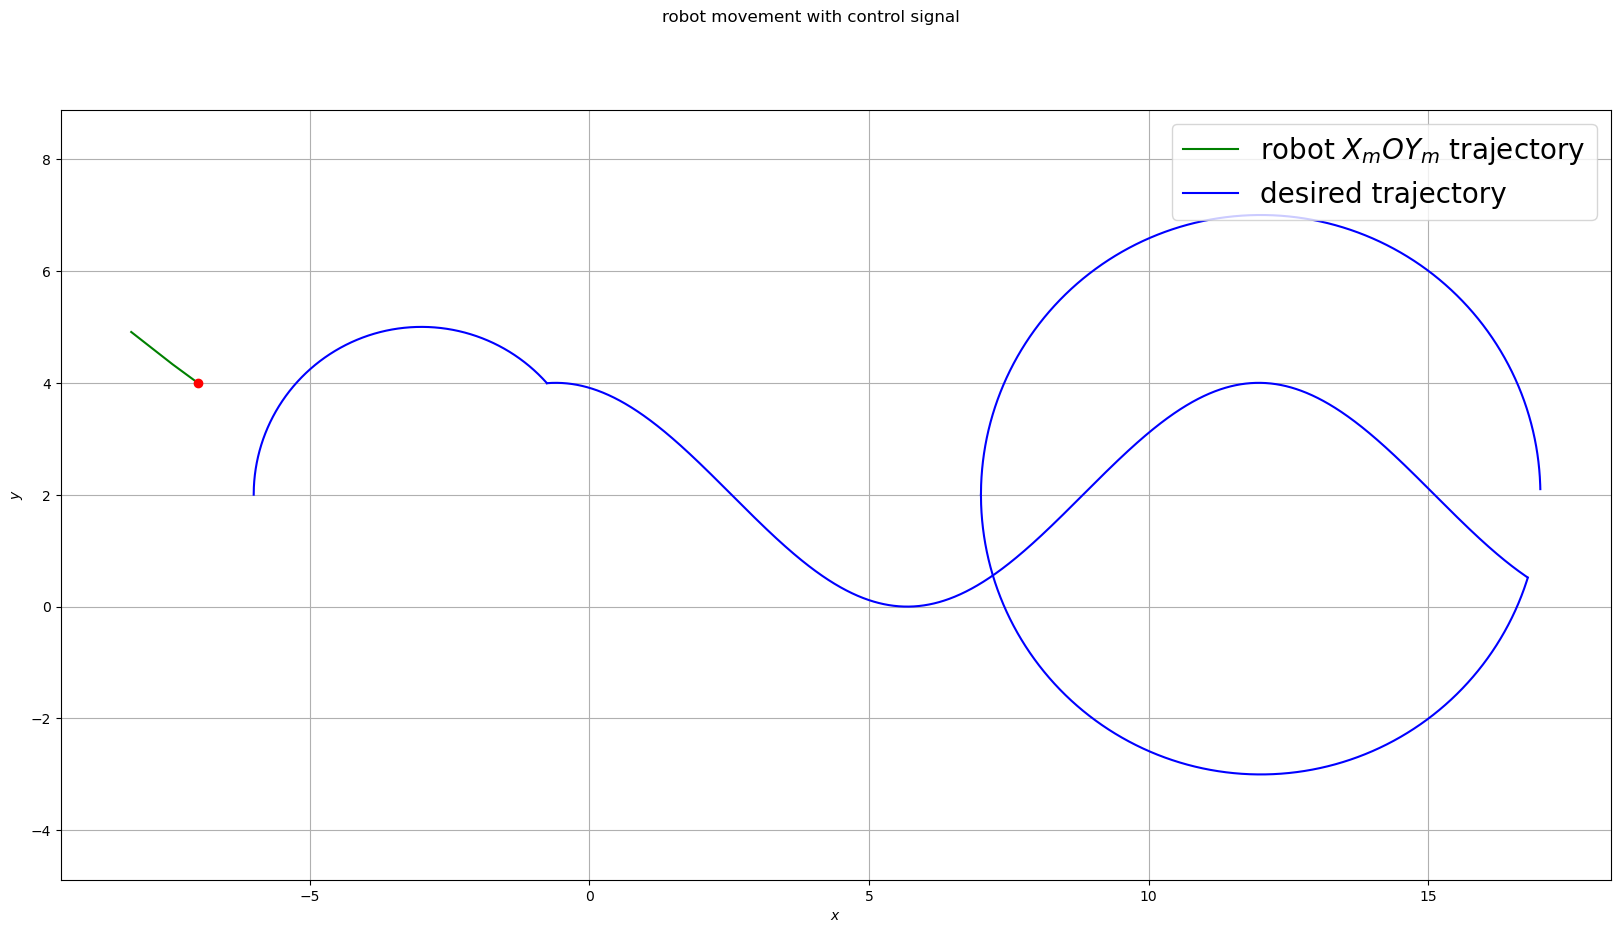

In [180]:
# t = sol.t
# z_traj = sol.y
# t = sol.t
z_traj = y

fig, ax = plt.subplots(1,1,figsize = (20,10))
labels = ['robot $X_mOY_m$ trajectory','desired trajectory']
colours = ['g','b']
ax.plot(z_traj[3],z_traj[4],label=labels[0],color=colours[0])
plt.plot(x1,fun_calc_phi_12_y(x1),"-",color=colours[1],label=labels[1])
plt.plot(x2,fun_calc_phi_2_y(x2),"-",color=colours[1])
plt.plot(x3,fun_calc_phi_31_y(x3),"-",color=colours[1])
plt.plot(x4,fun_calc_phi_32_y(x4),"-",color=colours[1])
plt.plot(x0,y0,"or")

fig.suptitle("robot movement with control signal")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.grid(True)
ax.legend(fontsize="20",loc='upper right')
ax.axis('equal')
plt.show()

# fig, ax = plt.subplots(2,4,figsize = (20,8))
# for i in range(2):
#     for j in range(4):
#         ax[i][j].grid(True)
# plt.subplot(241)
# plt.plot(t,z1_traj[0],"-b")
# plt.plot(t,x_des,"--",color="orange")
# plt.title("$z_{1_{11}}$ or P''x")
# plt.subplot(242)
# plt.plot(t,z1_traj[1])
# plt.plot(t,y_des,"--",color="orange")
# plt.title("$z_{1_{21}}$ or P''y")
# plt.subplot(243)
# plt.plot(t,z1_traj[6] )
# plt.title("vartheta")
# plt.subplot(244)
# plt.plot(t,z1_traj[7])
# plt.title("beta_s1")
# plt.subplot(245)
# plt.plot(t,z1_traj[2])
# plt.title("beta_s2")

# eta_v = np.array([])
# zeta_1_v = np.array([])
# zeta_2_v = np.array([])
# for i in range(len(t)):
#     u_v = np.dot( fun_Kinv(z1_traj[2][i], z1_traj[6][i], z1_traj[7][i]), np.array([z1_traj[3][i],z1_traj[4][i],z1_traj[5][i]]).reshape(3,1) )
#     eta_v = np.append(eta_v,u_v[0][0])
#     zeta_1_v = np.append(zeta_1_v,u_v[1][0])
#     zeta_2_v = np.append(zeta_2_v,u_v[2][0])

# plt.subplot(246)
# plt.plot(t,eta_v)
# plt.title("eta")
# ax[1][1].set_ylim([-10000,10000])
# plt.subplot(247)
# plt.plot(t,zeta_1_v)
# plt.title("zeta_1")
# ax[1][2].set_ylim([-10000,10000])
# plt.subplot(248)
# plt.plot(t,zeta_2_v)
# plt.title("zeta_2")
# plt.show()